## 텍스트 임베딩 이해하기
여러 문장의 텍스트를 임베딩 벡터로 변환하는 방식을 텍스트 임베딩 또는 문장 임베딩이라고 부른다.<br>
**임베딩** 이란 데이터의 의미를 압축한 숫자 배열(벡터)를 말한다.

### 문장 임베딩 방식의 장점
- 문장 임베딩 방식을 사용하면 서로 다른 텍스트를 마치 사람이 이해하는 것처럼 서로 유사한지 관련이 있는지 판단할 수 있다.

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

smodel = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
dense_embedding = smodel.encode(['학교','공부','운동','과제','숙제','등교','선생','학생'])
cosine_similarity(dense_embedding)

array([[1.        , 0.59507436, 0.32537565, 0.3418821 , 0.5814683 ,
        0.5519421 , 0.6284327 , 0.70323765],
       [0.59507436, 0.9999998 , 0.54595715, 0.40079993, 0.65701014,
        0.44192743, 0.51854885, 0.58688104],
       [0.32537565, 0.54595715, 1.0000001 , 0.22613424, 0.27951938,
        0.26750943, 0.25443447, 0.28086746],
       [0.3418821 , 0.40079993, 0.22613424, 1.        , 0.62416506,
        0.25672954, 0.34852365, 0.41661996],
       [0.5814683 , 0.65701014, 0.27951938, 0.62416506, 1.0000001 ,
        0.5026746 , 0.4425594 , 0.51661015],
       [0.5519421 , 0.44192743, 0.26750943, 0.25672954, 0.5026746 ,
        0.9999998 , 0.28734636, 0.40774575],
       [0.6284327 , 0.51854885, 0.25443447, 0.34852365, 0.4425594 ,
        0.28734636, 0.99999994, 0.71154207],
       [0.70323765, 0.58688104, 0.28086746, 0.41661996, 0.51661015,
        0.40774575, 0.71154207, 0.99999994]], dtype=float32)

### 원핫 인코딩
- 데이터를 숫자로 변환한다면 간단히 1,2,3,4,5 아이디로 붙일수있다. 숫자로 변환했지만 2는 1의 2배 라는 오해가 생길 수 있어 이런 문제를 피하기 위해 원핫인코딩을 사용한다.


In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

word_dict = {'school':np.array([[1,0,0]]),'study':np.array([[0,1,0]]),'workout':np.array([[0,0,1]])}
cosine_similarity(word_dict['school'],word_dict['study'])

array([[0.]])

### Back of Words
- 비슷한 단어가 많이 다오면 비슷한 문장 또는 문서 라는 가정을 활용해 문서를 숫자로 변환한다.<br>
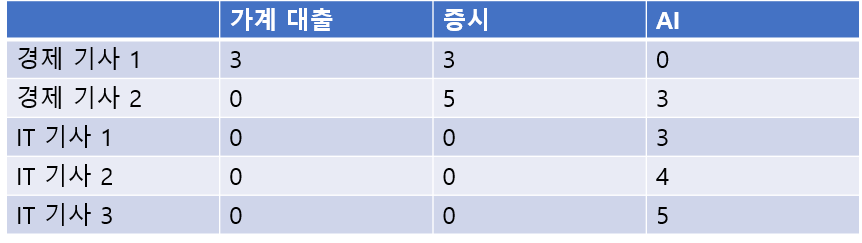<br>
- 경제 기사라면 '대출','증시'라는 단어가 많이 나올 가능성이 높다.
- IT 기사에도 나올 수 있지만 경제 기사보다 낮은 빈도를 보일 것이다.
- 백오브워즈의 문제는 단어가 많이 나왔다고 해 문서의 의미파악에 크게 도움이 되지 않는 경우가 있다. 예를 들어 '은/는/이/가,을/를'과 같은 조사

### TF-IDF
- 어느 문서에나 나오는 단어 문제를 보완하기 위해 많은 문서에 등장하는 단어의 중요도를 작게 만든다.
$$TF-IDF(w) = TF(w) \times log(N/DF(w)) $$
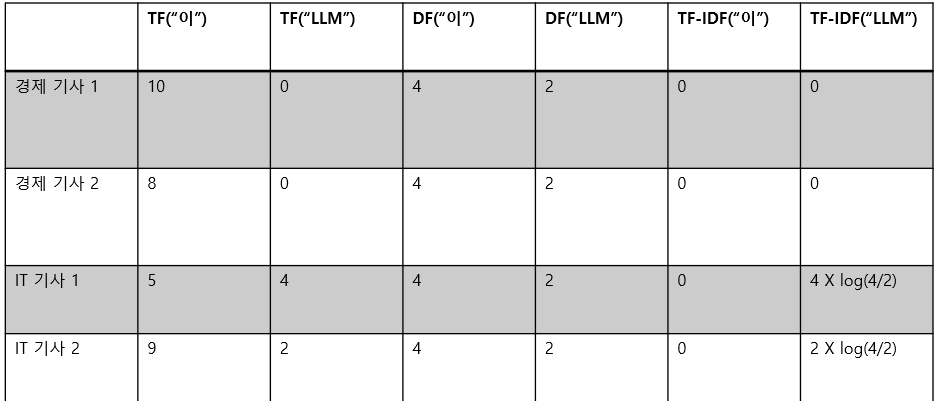<br>
- 전체 문서의 수가 ($N$) 4 일때 'AI'라는 단어는 3개의 문서에 등장했으므로 DF("AI") = 3이다. $log(N/DF(w))$는 특정 단어가 여러 문서에 등장할수록 값이 작아지는데, 만약 '이'라는 조사가 4개의 문서에 모두 등장했다면 $log(N/DF('이')) = log(4/4) = 0$ 이 된다.
- 조사 '이'는 'LLM'에 비해 IT 기사에서 더 많이 등장하지만 모든 문서에 등장했기 때문에 중요도가 없다고 판단해 TF-IDF("이") 값은 0이 된다. 

### Word2Vec
- 워드투백은 '함께 등장하는 빈도'정보를 활용해 단어의 의미를 압축하는 단어 임베딩 방법이다.예를 들어 "AI"는 "ML"또는 "머신러닝"과 "한강"은 "라면"같은 단어가 함께 자주 등장한다.
- **특정 단어 주변에 어떤 단어가 있는지 예측하는 모델을 만든다면 단어의 의미를 표현한 임베딩을 모델이 생성하지 않을까 라는 가정을 기반한다.**<br>
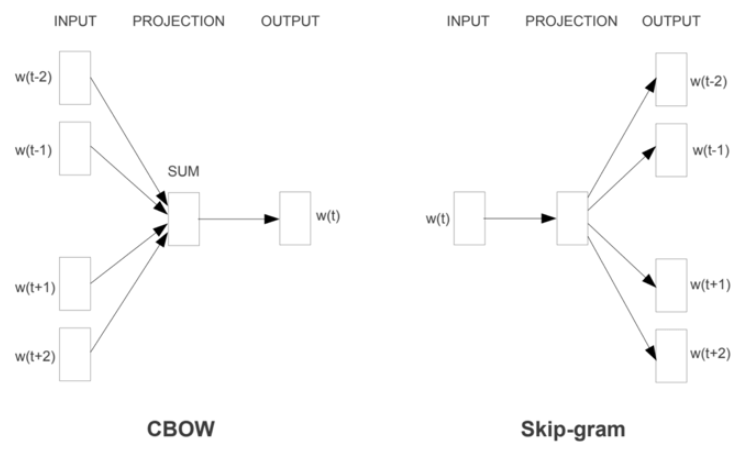<br>
-  주변 단어로 가운데 단어를 예측하는 방식(CBOW)과 중간 단어로 주변 단어를 예측하는 방식(SkipGram)으로 모델을 학습시킨다.
-  CBOW에서는 t 번째 단어를 예측하기 위해 위아래로 2개의 단어 정보(t-2,t-1,t+1,t+2번째)를 활용한다.
-  스킵그램은 반대로 t번째 단어 정보로 주변의 4개의 단어(t-2,t-1,t+1,t+2)가 무엇인지 맞추는 방식으로 학습한다.<br>
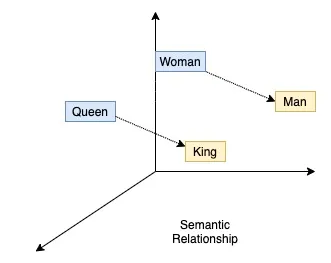<br>
- 이렇게 주변 단어를 예측하는 방식을 사용한 모델로 단어를 벡터로 변환했을 때 'woman'이라는 단어의 임베딩 벡터와 'Man'이라는 단어의 임베딩 벡터사이의 거리 방향이 'Queen','King'사이의 거리 및 방향이 비슷하게 나왔다. <span style='color:blue'>**단어와 단어 사이의 관계를 계산할 수 있고,그 관계에도 의미가 담겨 있음을 확인한 것이다.**</span>

## 문장 임베딩 방식

### 문장 사이의 관계를 계산하는 두 가지 방법
- 트랜스포머 인코더 구조를 활용한 BERT모델은 입력 문장을 문장 임베딩으로 변환하는 데 있어 뛰어난 성능을 보였다.문장사이 관계를 계산하는 방법은 크게 두가지로 나울 수 있다.<br>
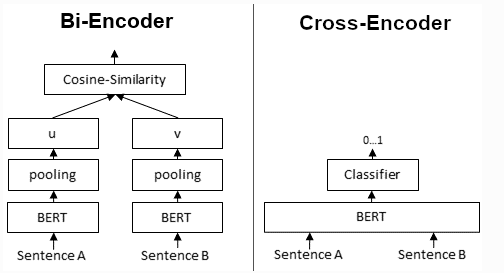<br>
    - Bi-Encoder : sentence A 와 Sentence B를 독립적으로 BERT 모델에 입력으로 넣고 모델의 출력 결과인 문장 임베딩 벡터($u,v$) 사이의 유사도를 cosine similarity와 같은 별도의 계산을 통해 구한다. pooling 층은 문장의 길이가 달라져도 문장 임베딩 차원이 같도록 맞춰주는 층
    - Cross-Encoder : 두 문장을 입력으로 넣고 문장 사이의 관계를 0 - 1 사이의 값으로 출력한다. Bi-Encoder에 비해 계산량이 많지만 상호작용을 고려할 수 있어 좀 더 정확한 관계 예측이 가능하다.<br>
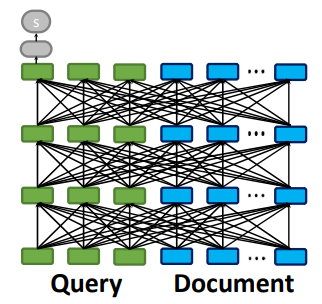<br>
Cross-Encoder 방식은 하나의 BERT 모델에 Query 문장과 Document을 함께 입력으로 넣고 텍스트 사이의 유사도 점수($s$)를 계산한다. **두 텍스트 사이의 관계를 모두 계산하기 때문에 두 텍스트의 유사도를 정확히 계산할 수 있다는 장점이 있다.** 하지만 입력으로 넣은 두 문장의 유사도만 계산하기 때문에 다른 문장과 검색 쿼리의 유사도를 알고 싶으면 다시 동일한 연산을 반복해야 한다는 단점이 있다.<br>
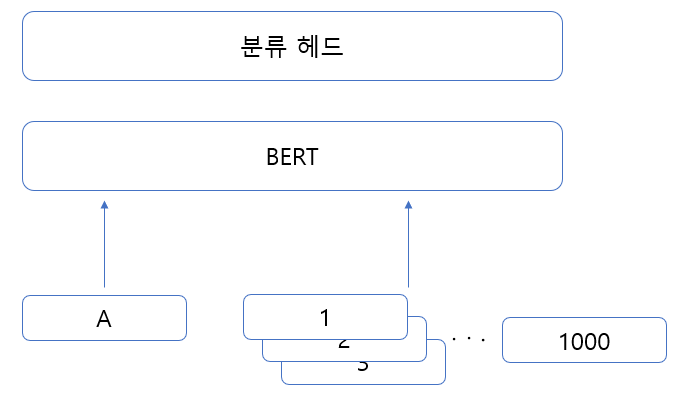<br>
1000개의 문장을 저장하고 있을 때 문장 A와 가장 유사한 문장을 찾고 싶다면 문장 1부터 1000까지 모두 계산해 1000번의 계산을 거쳐야 한다.하지만 BERT 모델이 사용하는 어텐션 연산은 계산량이 많은 무거운 연산이기 때문에 가급적 적게 수행해야 한다.
문장 B가 온다면 또 1000번의 연산을 수행해야 한다. <br>
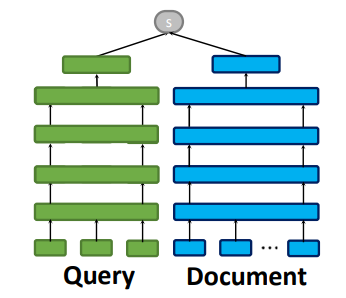<br>
이 문제를 극복하기 위해 Bi-Encoder 방식이 개발됐다. 그림에서 각 문장은 동일한 모델을 통과해 각 문장에 대한 임베딩으로 변환한다.그리고 두 문장 사이의 유사도는 각 문장 임베딩을 코사인 유사도와 같은 유사도 계산 방식을 통해 최종적인 유사도 점수($s$)를 산출한다. Bi-Encoder는 각 문장의 **독립적인 임베딩을 결과로 반환하기 때문에 유사도 계산하고 싶은 문장이 바뀌어도 추가적인 BERT 연산이 필요없다.**<br>
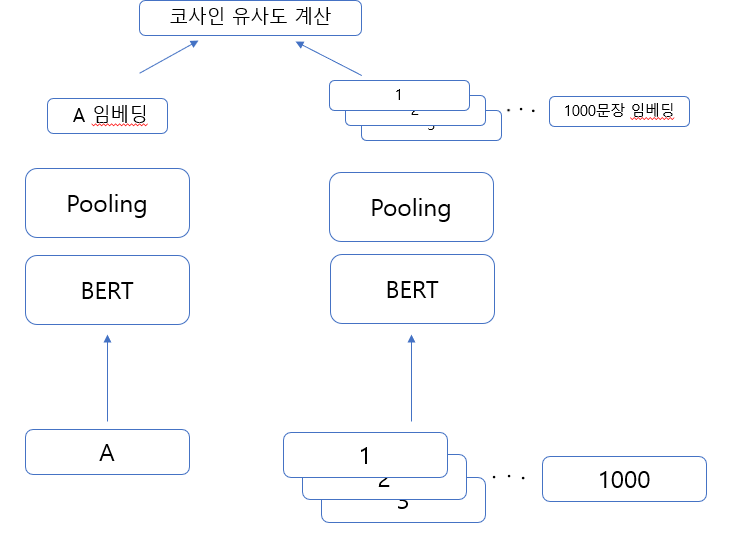<br>
저장된 1000개 문장 중 A와 가장 유사한 문장을 찾고 있을 때 Bi-Encoder를 통해 문장 A에 대한 문장 임베딩을 생성하고 문장 1부터 1000까지 1000개의 문장에 대한 문장 임베딩을 생성한다. 그리고 문장 임베딩 끼리 코사인 유사도를 사용해 유사도 점수를 계산한다.<br>
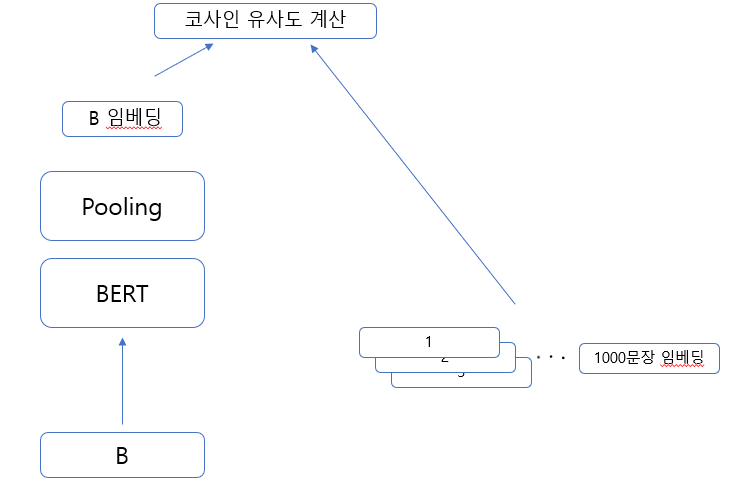<br>
강점은 새로운 문장을 검색할 때 드러난다. 새로운 문장 B와 가까운 문장을 찾는 경우 1~1000까지 임베딩은 이미 만들었기 때문에 문장 B를 임베딩으로 만드는 한번의 BERT 연산만 수행하면 유사한 문장을 검색 할 수 있다. 


### Bi-Encoder 모델 구조
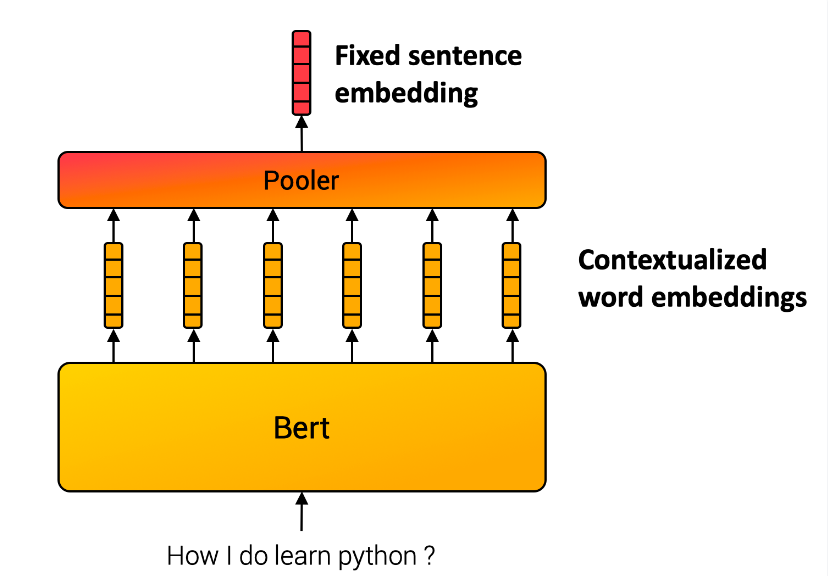<br>
바이 인코더는 BERT 모델의 출력을 pooling층을 통해 고정된 크기의 문장 임베딩으로 만든다. BERT 모델은 입력 토큰마다 출력 임베딩을 생성한다. 따라서 입력하는 문장의 길이가 달라질 경우 출력하는 임베딩의 수가 달라진다. 문장의 길이가 다를 때 서로 다른 개수의 임베딩이 반환되면 문장과 문장 사이의 유사도를 쉽게 계산하기 어렵다.따라서 풀링 층을 사용해 문장을 대표하는 1개의 임베딩으로 통합한다. <span style='background-color:yellow'>문장의 길이가 달라져도 풀링층을 통해 1개의 고정된 차원의 임베딩이 반환되기 때문에 코사인 유사도와 같은 거리 계산 방식을 활용해 두 문장 임베딩 사이의 거리를 쉽게 계산할 수 있다.</span>

In [5]:
from sentence_transformers import SentenceTransformer , models
# 사용할 모델
word_embedding_model = models.Transformer('klue/roberta-base')
# 풀링 층 차원
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#두 모듈 결합
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

- pooling_mode는 언어 모델이 출력한 결과 임베딩을 고정된 크기의 문장 임베딩으로 통합할 때 통합하는 방식을 말한다.
    - 클래스 모드(cls_tokens) : BERT 모델의 첫 번째 토큰인 [CLS] 토큰의 출력 임베딩을 문장 임베딩으로 사용
    - 평균 모드(means_tokens) : BERT 모델에서 모든 입력 토큰의 출력 임베딩을 평균한 값을 문장 임베딩으로 사용
    - 최대 모드(max_tokens) : BERT 모델의 모든 입력 토큰의 출력 임베딩에서 문장 길이(sequence)방향에서 최대값을 찾아 문장 임베딩으로 사용

In [6]:
# pooling_mode_means_tokens

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min = 1e-9)
    return sum_embeddings / sum_mask

**평균 모드 코드** <br>
1. mean_pooling 함수의 입력으로 model_output과 attention_mask를 받는데, 여기서 model_output은 언어 모델의 출력이고 attention_mask는 패딩 토큰의 위치를 확인할 수 있는 어텐션 마스크다.
2. model_output[0]을 통해 언어 모델의 출력 중 마지막 층의 출력만 사용한다.
3. 입력이 패딩 토큰인 부분은 평균 계산에서 무시하기 위해 input_maks_expanded를 만들고 출력 임베딩에 곱해 준다.
4. 마지막으로 출력 임베딩의 합을 패딩 토큰이 아닌 실제 토큰 입력의 수로 나눠준다.

In [7]:
# 최대 모드
def max_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9
    return torch.max(token_embeddings,1)[0]

**최대 모드 코드**<br>
1. 어텐션 마스크를 통해 패딩 토큰 부분 구분까지는 동일
2. 패딩 토큰인 부분은 $-1e9$로 아주 작은 값을 입력해 최대값이 될 수 없도록 설정하고 출력 임베딩의 토큰 길이 차원에서 가장 큰값을 찾음

### Sentence-Transformer로 텍스트와 이미지 임베딩 


In [8]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

embs = model.encode(['잠이 안 옵니다',
                     '졸음이 옵니다',
                     '기차가 옵니다'])

cos_scores = util.cos_sim(embs, embs)
print(cos_scores)

tensor([[1.0000, 0.6410, 0.1887],
        [0.6410, 1.0000, 0.2730],
        [0.1887, 0.2730, 1.0000]])


1. 문장 임베딩 모델은 encode 메서드를 통해 입력 문장을 문장 임베딩으로 변환
2. 각 문장 사이의 유사도 계산을 위해 util.cos_sim함수를 사용해 문장 사이의 코사인 유사도 계산

In [10]:
from PIL import Image
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')

img_embs = model.encode([Image.open('dog.jpg'), Image.open('cat.jpg')])
text_embs = model.encode(['A dog on grass', 'Brown cat on yellow background'])

cos_scores = util.cos_sim(img_embs, text_embs)
print(cos_scores)

tensor([[0.2771, 0.1510],
        [0.2071, 0.3181]])


CLIP 모델은 openAI가 개발한 텍스트-이미지 멀티 모달모델로 이미지와 텍스트 임베딩을 동일한 벡터 공간상에 배치해 유사한 텍스트와 이미지를 찾을 수 있다. 
1. encode메서드로 강아지,고양이 이미지를 이미지 임베딩으로 변환하고 문장을 텍스트 임베딩으로 변환한다.
2. 이미지와 텍스트 사이의 코사인 유사도를 계산하면 강아지와 강아지 텍스트의 유사도는 0.2771이지만 고양이 이미지와  강아지 텍스트의 유사도는 0.2071로 더 높다.

## 의미 검색(sementic search) 구현

## 의미 검색
- 의미 검색(sementic search)란 단순히 키워드 매칭을 통한 검색이 아니라 **밀집 임베딩을 이용해 문장이나 문서의 의미를 고려한 검색을 수행 하는것**


### 라마인덱스에서 Sentence-Transformers 모델 사용하기

In [6]:

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

klue_mrc_dataset = load_dataset('klue', 'mrc', split='train')
sentence_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

klue_mrc_dataset = klue_mrc_dataset.train_test_split(train_size=1000, shuffle=False)['train']
embeddings = sentence_model.encode(klue_mrc_dataset['context'])
embeddings.shape

C:\Users\ktaek\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


(1000, 768)

In [ ]:
import faiss
# 인덱스 만들기
index = faiss.IndexFlatL2(embeddings.shape[1])
# 인덱스에 임베딩 저장하기
index.add(embeddings)

In [18]:
!pip install llama-index-embeddings-huggingface

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 640.0 kB/s eta 0:00:03
   ---------------------------------------  1.6/1.6 MB 20.0 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------  1.5/1.5 MB 93.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
  Attempting uninstall: llama-index-core
    Found existing installation: llama-index-core 0.10.68.post1
    Uninstalling llama-index-core-0.10.68.post1:
      Successfully uninstalled llama-index-core-0.10.68.post1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.7.77 requires huggingface-hub==0.22.2, but you have huggingface-hub 0.26.1 which is incompatible.
autotrain-advanced 0.7.77 requires nltk==3.8.1, but you have nltk 3.9.1 which is incompatible.
autotrain-advanced 0.7.77 requires packaging==24.0, but you have packaging 23.2 which is incompatible.
autotrain-advanced 0.7.77 requires pydantic==2.7.1, but you have pydantic 2.9.2 which is incompatible.
autotrain-advanced 0.7.77 requires tiktoken==0.6.0, but you have tiktoken 0.7.0 which is incompatible.
autotrain-advanced 0.7.77 requires transformers==4.40.1, but you have transformers 4.45.2 which is incompatible.
llama-index 0.10.34 requires llama-index-core<0.11.0,>=0.10.34, but you have llama-index-core 0.11.21 which is incompatible.
llama-index-agent-openai 0.2.9 requires llama-index-core<0.11.0,

In [19]:
from llama_index.core import VectorStoreIndex, ServiceContext
from llama_index.core import Document
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="snunlp/KR-SBERT-V40K-klueNLI-augSTS")
service_context = ServiceContext.from_defaults(embed_model=embed_model, llm=None)
# 로컬 모델 활용하기
# service_context = ServiceContext.from_defaults(embed_model="local")

text_list = klue_mrc_dataset[:100]['context']
documents = [Document(text=t) for t in text_list]

index_llama = VectorStoreIndex.from_documents(
    documents,
    service_context=service_context,
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\ktaek\AppData\Local\Temp\ipykernel_29188\3419246948.py:6: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(embed_model=embed_model, llm=None)


LLM is explicitly disabled. Using MockLLM.


## 검색 방식 조합해 성능 높이기
- 키워드 검색은 의미 검색과 달리 동일한 키워드가 많이 포함될수록 유사도를 높게 평가하는 검색 방식을 말한다.따라서 키워드 검색은 동일한 키워드가 등장한 문서를 상위 검색 결과로 반환하기 떄문에 관련성이 떨어지는 검색 결과가 나타날 가능성이 낮다는 장점이 있고, 동일 키워드를 사용하지 않으면 의미가 유사하더라도 검색하지 못한다는 단점이 있다.

### BM5
- BM5는 TF-IDF와 유사한 통계 기반 스코어링 방법으로 TF-IDF에 문서의 길이에 대한 가중치를 추가한 알고리즘이다.
- BM5는 간단하고 계산량이 적으면서도 뛰어난 성능을 보여 대표적인 검색엔진인 Elasticsearch의 기본알고리즘으로 사용된다.<br>
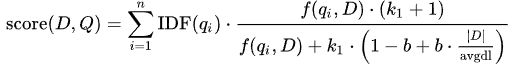<br>
- 수식은 복잡해 보이지만 TF-IDF와 유사하다. 왼쪽 부분이 TF-IDF의 문서 빈도 부분으로 특정단어($q_i$)가 전체 문서에서 얼마나 자주 등장했는지를 나타내고, 오른쪽이 TF와 대응되는 부분으로 특정문서($D$)내에서 특정 단어가 얼마나 많이 등장했는지를 나타낸다. 식에서 $avgdl$은 전체 문서의 평균 길이를 나타내고 $k_1$과 $b$는 선택할 수 있는 설정 값이다.<br>
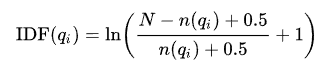<br>
- IDF 부분을 보면 $n(q_1)$은 쿼리 단어의 토큰 $q_i$가 등장한 문서의 수이고, $N$은 전체 문서의 수다. 만약 모든 문서에 등장하는 토큰이라면 IDF 부분은 최솟값이 되고 적게 등장하면 IDF는 커진다.<br>
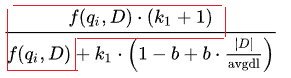<br>
- TF 부분의 $f(q_i,D)$는 특정 문서 $D$에 토큰 $q_i$가 등장한 횟수고 $|D|$는 $D$ 문서의 길이,$avgdl$은 전체 문서의 평균 길이다. $k_1$은 단어 빈도에 대한 포화 효과를 주는 하이퍼파라미터인데 식의 빨간 부분을 보면 해당 문서 $q$의 등장 빈도가 높아진다고 했을 때 빨간 부분의 값은 $(k_1+1)$에 가까워진다. $f(q_i,D)$가 아무리 커져도 $(k_1+1)$에 가까워지기만 할 뿐 무한정 커지지 않기 때문에 포화 효과를 의미한다.<br>
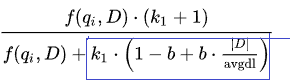<br>
- $|D|/avgdl$부분은 문서 길이에 대한 가중치인데, 만약 평균 문서 길이를 100이라고 했을 때 짧은 문서(예: 5)일 때가 긴 문서(예:150)일 때보다 B의 크기가 작아지고, 결과적으로 전체 식의 값이 커진다. 따라서 **짧은 문서에 토큰 $q$가 등장한 경우 더 중요도를 높게 판단한다고 이해할 수 있다. 변수 $b$는 문서 길이 효과를 반영하는 비율을 의미한다. $b$가 클루록 문서 길이 효과를 더 크게 반영한다.**<br>
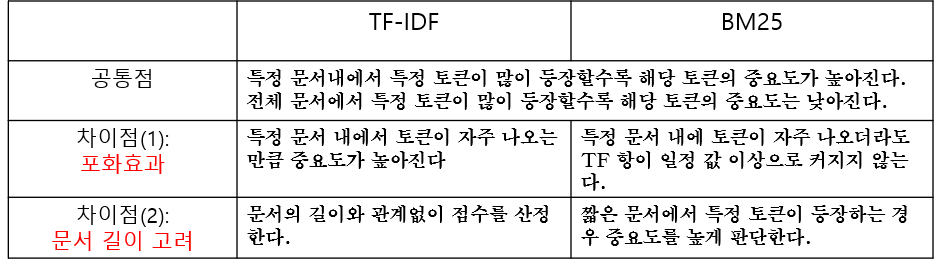<br>

### 상호 순위 조합 
- 하이브리드 검색을 위해서는 통계 기반 점수와 임베딩 유사도 점수를 하나로 합쳐야 한다.하지만 점수마다 분포가 다르기 때문에 두 점수를 그대로 더하면 둘 중 하나의 영향을 더 크게 반영하게 된다.예를들어 A와 B 점수를 결합해 사용하는데 A 점수는 0-100점으로 분포하고 B 점수는 1-10점으로 분포한다면 그대로 더할 경우 A점수의 영향이 더 크게 반영된다.
- 이 문제를 해결하기 위해 상호 순위 조합(Reciprocal Rank Fusion,RRF)은 각 점수에서의 순위를 활용해 점수를 산출한다.<br>
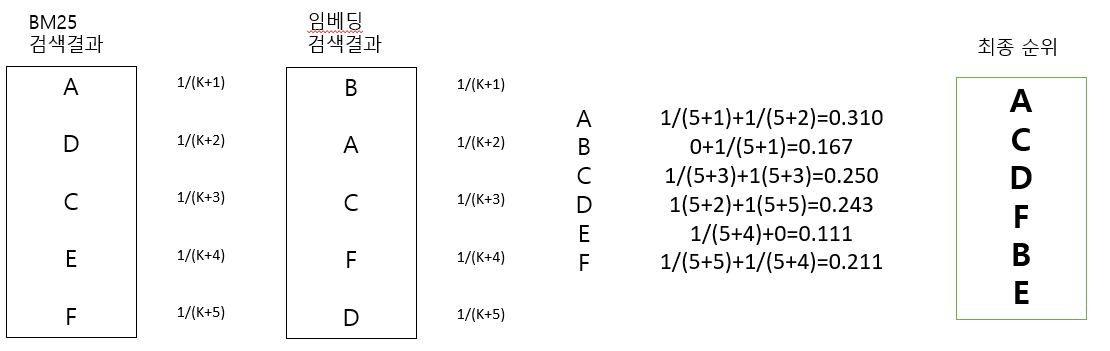<br>
- 각 점수 산정 방식에 따라 순위를 정한다. BM25와 밀집 임베딩 방식을 활용한다고 가정했을때 순위에 따라 $(1/(k+순위))$를 부여한다. 여기서 $k$는 조절가능한 인자다. $k$를 5로 두고 점수를 계산했을 때 양쪽 점수를 문서별로 더한다. 만약 한쪽 점수에서 순위에 들지 못했다면 0점으로 계산한다. 두 점수를 합쳤을 때 큰 순서대로 최종 순위를 결정한다.

### BM25 구현

In [1]:
import math
import numpy as np
from typing import List
from transformers import PreTrainedTokenizer
from collections import defaultdict

class BM25:
  def __init__(self, corpus:List[List[str]], tokenizer:PreTrainedTokenizer):
    self.tokenizer = tokenizer
    self.corpus = corpus
    self.tokenized_corpus = self.tokenizer(corpus, add_special_tokens=False)['input_ids']
    self.n_docs = len(self.tokenized_corpus)
    self.avg_doc_lens = sum(len(lst) for lst in self.tokenized_corpus) / len(self.tokenized_corpus)
    self.idf = self._calculate_idf()
    self.term_freqs = self._calculate_term_freqs()

  def _calculate_idf(self):
    idf = defaultdict(float)
    for doc in self.tokenized_corpus:
      for token_id in set(doc):
        idf[token_id] += 1
    for token_id, doc_frequency in idf.items():
      idf[token_id] = math.log(((self.n_docs - doc_frequency + 0.5) / (doc_frequency + 0.5)) + 1)
    return idf

  def _calculate_term_freqs(self):
    term_freqs = [defaultdict(int) for _ in range(self.n_docs)]
    for i, doc in enumerate(self.tokenized_corpus):
      for token_id in doc:
        term_freqs[i][token_id] += 1
    return term_freqs

  def get_scores(self, query:str, k1:float = 1.2, b:float=0.75):
    query = self.tokenizer([query], add_special_tokens=False)['input_ids'][0]
    scores = np.zeros(self.n_docs)
    for q in query:
      idf = self.idf[q]
      for i, term_freq in enumerate(self.term_freqs):
        q_frequency = term_freq[q]
        doc_len = len(self.tokenized_corpus[i])
        score_q = idf * (q_frequency * (k1 + 1)) / ((q_frequency) + k1 * (1 - b + b * (doc_len / self.avg_doc_lens)))
        scores[i] += score_q
    return scores

  def get_top_k(self, query:str, k:int):
    scores = self.get_scores(query)
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_scores = scores[top_k_indices]
    return top_k_scores, top_k_indices

BM25 연산을 수행하는 클래스를 정의한다. 저장한 문서와 점수를 계산하는 get_scores와 상위 k개의 점수와 인덱스를 추출하는 get_top_k를 구현한다. _calculate_idf 는 각 토큰이 몇개의 문서에 등장하는지 집계한다. 토큰화한 텍스트 데이터를 순회하면서 토큰 아이디마다 총 몇개의 문서에 등장하는지 idf 딕셔너리에 저장한다.<br> 다음으로 _calculate_term_freqs 메서드로 토큰이 문서내에서 몇번 등장하는지 집계한다. 문서 수(self.n_docs)만큼의 딕셔너리를 만들고 각 문서 내에서 어떤 토큰이 등장하는지 집계한다.<br>
get_scores 메서드에서는 앞서 만든 idf와 term_freqs를 통해 검색하려는 쿼리와 각 문서 사이의 점수를 계산한다<br>
get_top_k 쿼리와 문서 사이의 점수가 가장 높은$k$개의문서의 인덱스와 점수를 반환한다.

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

bm25 = BM25(['안녕하세요', '반갑습니다', '안녕 서울'], tokenizer)
bm25.get_scores('안녕')

array([0.44713859, 0.        , 0.52354835])

In [7]:
bm25 = BM25(klue_mrc_dataset['context'], tokenizer)

query = "이번 연도에는 언제 비가 많이 올까?"
_, bm25_search_ranking = bm25.get_top_k(query, 100)

for idx in bm25_search_ranking[:3]:
  print(klue_mrc_dataset['context'][idx][:50])

Token indices sequence length is longer than the specified maximum sequence length for this model (965 > 512). Running this sequence through the model will result in indexing errors


갤럭시S5 언제 발매한다는 건지언제는 “27일 판매한다”고 했다가 “이르면 26일 판매한다
인구 비율당 노벨상을 세계에서 가장 많이 받은 나라, 과학 논문을 가장 많이 쓰고 의료 특
올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 


의미 검색의 한계를 살펴봤을 때 "이번 연도에는 언제 비가 많이 올까?"를 검색 쿼리문장으로 사용해 BM25 클래스를 수행했을 때 쿼리 문장을 get_top_k 메서드에 입력하고 상위 100개의 문서를 찾는다. 검색 결과를 확인하기 위해 3개의 검색 결과를 출력하지만 오답이 2개가 나오고 3번째 결과에 등장한다. **일치하는 키워드가 적어 가장 먼저 검색되지 않는 것이다.**

In [8]:
query = klue_mrc_dataset[3]['question']  # 로버트 헨리 딕이 1946년에 매사추세츠 연구소에서 개발한 것은 무엇인가?
_, bm25_search_ranking = bm25.get_top_k(query, 100)

for idx in bm25_search_ranking[:3]:
  print(klue_mrc_dataset['context'][idx][:50])

미국 세인트루이스에서 태어났고, 프린스턴 대학교에서 학사 학위를 마치고 1939년에 로체스
;메카동(メカドン)
:성우 : 나라하시 미키(ならはしみき)
길가에 버려져 있던 낡은 느티나
;메카동(メカドン)
:성우 : 나라하시 미키(ならはしみき)
길가에 버려져 있던 낡은 느티나


BM25 검색 결과의 장점으로 보면 '매사추세츠 연구소'라는 표현이 많이 등장하는데 BM25는 일치하는 키워드를 바탕으로 관련된 기사를 잘 찾았다.

### 상호 순위 조합 구현

In [9]:
from collections import defaultdict

def reciprocal_rank_fusion(rankings:List[List[int]], k=5):
    rrf = defaultdict(float)
    for ranking in rankings:
        for i, doc_id in enumerate(ranking, 1):
            rrf[doc_id] += 1.0 / (k + i)
    return sorted(rrf.items(), key=lambda x: x[1], reverse=True)

reciprocal_rank_fusion 함수는 각 검색 방식으로 계산해 정해진 문서의 순위를 입력으로 받아 상호 순위 조합 점수가 높은 순서대로 정렬해서 반환한다.이 함수는 입력으로 여러 검색 방식에서 정해진 유사한 문서의 인덱스 리스트(rankings)를 입력으로 받는다. 이후 각각 순위 리스트를 순회하며 각각 문서 인덱스(doc_id)에 1/(k+순위)의 점수를 더한다.마지막으로 점수를 종합한 딕셔너리(rrf)를 점수에 따라 높은 순으로 정렬해 반환한다.

In [10]:
rankings = [[1, 4, 3, 5, 6], [2, 1, 3, 6, 4]]
reciprocal_rank_fusion(rankings)

[(1, 0.30952380952380953),
 (3, 0.25),
 (4, 0.24285714285714285),
 (6, 0.2111111111111111),
 (2, 0.16666666666666666),
 (5, 0.1111111111111111)]

### BM25와 RRF를 합친 하이브리드 검색 구현

In [11]:
def dense_vector_search(query:str, k:int):
  query_embedding = sentence_model.encode([query])
  distances, indices = index.search(query_embedding, k)
  return distances[0], indices[0]

def hybrid_search(query, k=20):
  _, dense_search_ranking = dense_vector_search(query, 100)
  _, bm25_search_ranking = bm25.get_top_k(query, 100)
 
  results = reciprocal_rank_fusion([dense_search_ranking, bm25_search_ranking], k=k)
  return results

dense_vector_search 함수는 의미 검색에서 반복적으로 수행하던 검색 쿼리 문장 임베딩 변환과 인덱스 검색 부분을 한 번에 수행할 수 있도록 정의했다. hybrid_search 함수는 검색 쿼리 문장(query)과 상호 순위 조합에 사용할 파라미터 $k$를 입력으로 받는다<br>
입력으로 받은 쿼리문장으로 의미 검색과 BM25 키워드 검색을 수행한다. 마지막으로 상호 순위 조합을 사용해 두 검색 방식의 순위를 조합하고 결과를 반환한다.


In [15]:
#Faiss 구현
import numpy as np

class SimpleDenseIndex:
    def __init__(self):
        self.vectors = []
        self.doc_ids = []

    def add(self, vectors, doc_ids=None):
        """Add vectors to the index."""
        if doc_ids is None:
            doc_ids = range(len(self.vectors), len(self.vectors) + len(vectors))
        self.vectors.extend(vectors)
        self.doc_ids.extend(doc_ids)

    def search(self, query_vector, k=5, metric='cosine'):
        """Search for the top k nearest neighbors."""
        if metric == 'cosine':
            query_norm = np.linalg.norm(query_vector)
            vectors_norm = np.linalg.norm(self.vectors, axis=1)
            similarities = np.dot(self.vectors, query_vector) / (vectors_norm * query_norm)
            top_k_indices = np.argsort(similarities)[-k:][::-1]
        elif metric == 'euclidean':
            distances = np.linalg.norm(self.vectors - query_vector, axis=1)
            top_k_indices = np.argsort(distances)[:k]
        else:
            raise ValueError("Unsupported metric. Use 'cosine' or 'euclidean'.")

        top_k_scores = similarities[top_k_indices] if metric == 'cosine' else distances[top_k_indices]
        top_k_doc_ids = [self.doc_ids[idx] for idx in top_k_indices]
        
        return top_k_scores, top_k_doc_ids

# Example usage
index = SimpleDenseIndex()

In [ ]:
query = "이번 연도에는 언제 비가 많이 올까?"
print("검색 쿼리 문장: ", query)
results = hybrid_search(query)
for idx, score in results[:3]:
  print(klue_mrc_dataset['context'][idx][:50])

print("=" * 80)
query = klue_mrc_dataset[3]['question'] # 로버트 헨리 딕이 1946년에 매사추세츠 연구소에서 개발한 것은 무엇인가?
print("검색 쿼리 문장: ", query)

results = hybrid_search(query)
for idx, score in results[:3]:
  print(klue_mrc_dataset['context'][idx][:50])

# 출력 결과
# 검색 쿼리 문장:  이번 연도에는 언제 비가 많이 올까?
# 올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은  (정답)
# 갤럭시S5 언제 발매한다는 건지언제는 “27일 판매한다”고 했다가 “이르면 26일 판매한다  (오답)
# 연구 결과에 따르면, 오리너구리의 눈은 대부분의 포유류보다는 어류인 칠성장어나 먹장어, 그 (오답)
# ================================================================================
# 검색 쿼리 문장:  로버트 헨리 딕이 1946년에 매사추세츠 연구소에서 개발한 것은 무엇인가?
# 미국 세인트루이스에서 태어났고, 프린스턴 대학교에서 학사 학위를 마치고 1939년에 로체스 (정답)
# 1950년대 말 매사추세츠 공과대학교의 동아리 테크모델철도클럽에서 ‘해커’라는 용어가 처음 (오답)
# 1950년대 말 매사추세츠 공과대학교의 동아리 테크모델철도클럽에서 ‘해커’라는 용어가 처음 (오답)